## Imports

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


## Data Loading & Pre-Processing
- We load the dataset and clean it

In [36]:
# loads the dataset
df = pd.read_csv("../data/raw/SMSSpamCollection", sep="\t", header=None, names= ["label", "text"], encoding="latin-1")



#BAsic info of dataset
print(df.head())
print(df.label.value_counts())

#convert labels to binary
df["num_label"] = df["label"].map({"ham": 0, "spam": 1})
#
#Train & Test Split
x_train, x_test, y_train, y_test = train_test_split(df["text"], df["num_label"], test_size=0.2, random_state=42, stratify=df["num_label"])


#TF-IDF Vectorization (For testing purposes before actual td-idf was done)
# tfidf = TfidfVectorizer(stop_words="english", lowercase=True, max_features=5000)
# x_train_tfidf = tfidf.fit_transform(x_train)
# x_test_tfidf = tfidf.transform(x_test)

# print("TF-IDF shape:", x_train_tfidf.shape)

  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
label
ham     4825
spam     747
Name: count, dtype: int64


## Dimension Reduction Using SVD
- SVD reduces the huge TF-IDF matrix into a smaller set of hidden dimensions. Instead of representing each word desperately SVD groups together words that often appear in similar contexts. This means the reduced features capture semantic meaning not just raw word counts.


- In this dataset, this helps the model understand patterns like spam messages that often share similar themes like "Free" or "claim" or "urgent" or in contrast ham messages that use everyday conversational language


- The SVD components act like compressed topics that help logistic regression separate spam from ham more effectivity while also making the model faster and less noisy

SVD Reduced Shape: (4457, 100)


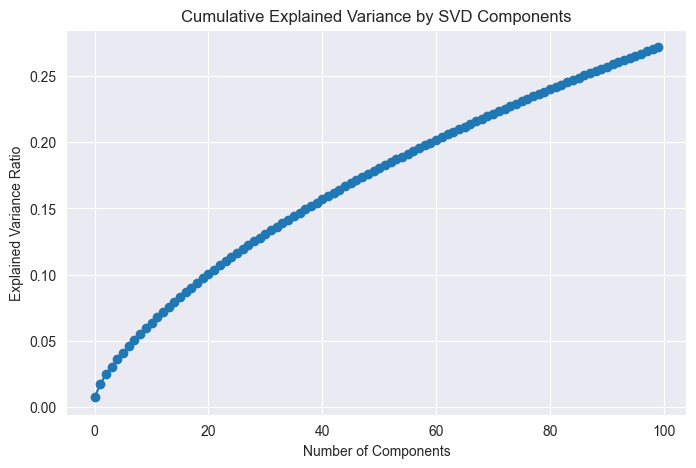

In [37]:
#Reduce to 100 components

#Reduce vectors to 100 components
svd= TruncatedSVD(n_components=100, n_iter=52)
#Fit SVD to training features
x_train_svd = svd.fit_transform(x_train_tfidf)

# Apply transofrmation to test features as well
x_test_svd = svd.transform(x_test_tfidf)

print("SVD Reduced Shape:", x_train_svd.shape)

#Variance plot

plt.figure(figsize=(8,5))
plt.plot(np.cumsum(svd.explained_variance_ratio_), marker="o")

plt.title("Cumulative Explained Variance by SVD Components")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)
plt.show()

## Model Training - Logistic Regression With SVD

In [38]:
#Create and train logistic regression classifier
log_svd = LogisticRegression(max_iter=5000)

log_svd.fit(x_train_svd, y_train)

#Precit labels for test set
y_pred_svd = log_svd.predict(x_test_svd)

#print accuracy
print("Accuracy (LogReg + SVD:", accuracy_score(y_test, y_pred_svd))
print(classification_report(y_test, y_pred_svd))

#Print Baseline Naive Bayes accuracy for comparison
# print("Baseline Naive Bayes Accuracy:", accuracy_score(y_test, nb_pred) ) #nb_pred placeholder for whatever it actually is when code is merged for performance anal
# print("Classification Report (Naive Bayes):")
# print(classification_report(y_test, y_pred_svd))


Accuracy (LogReg + SVD: 0.9515695067264573
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       966
           1       0.98      0.65      0.78       149

    accuracy                           0.95      1115
   macro avg       0.96      0.82      0.88      1115
weighted avg       0.95      0.95      0.95      1115



### Model Visualization Confusion Matrix

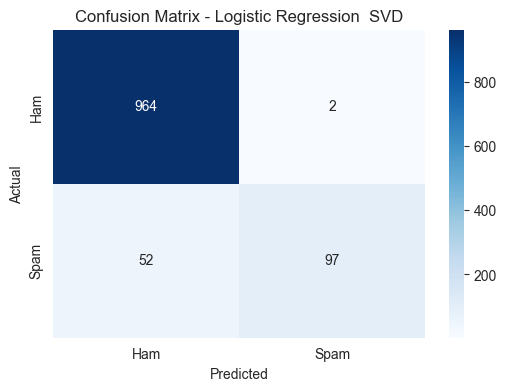

In [39]:
cm = confusion_matrix(y_test, y_pred_svd)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Ham", "Spam"],yticklabels=["Ham", "Spam"])
plt.title("Confusion Matrix - Logistic Regression  SVD")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### Interpretation
- TN: The model correctly classified 964 ham messages as ham which is almost perfect performance on normal messages

- FP: Only 2 ham messages were incorrectly predicted as spam which is very low false alarm rates

- FN: 52 spam messages were incorrectly predicted as ham which is a little more than we'd ideally want

- TP: The model correctly identifies 97 spam messages which is better but not perfect

- Overall the model is extremely reliable at identifying ham messages but still struggles with detecting every spam message

##### How does reducing dimensions affect model accuracy and speed?


- SVD reduces the number of features dramatically  which can maek training significantly  faster
- It also removes noise and correlations which often leads to improving stability & generalization in the model
- However, too much reduction could hurt accuracy so it's important to  apply the right amount of reduction typically a moderate amount is best


